# Sentiment Analysis Project with No RNNs

In [1]:
import os 
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
# a
def read_imdb(dataset_type, review_type):
    
    dataset_type, review_type = dataset_type.lower(), review_type.lower()
    if dataset_type != "train" and dataset_type != "test": raise ValueError("Choose from train or test.")
    if review_type != "pos" and review_type != "neg": raise ValueError("Choose from pos or neg.")    
    
    for roots, dirs, files in os.walk("./datasets/imdb/aclImdb/" + dataset_type + "/" + review_type):
        files = files
    return files 

train_pos = read_imdb("train", "pos")
train_neg = read_imdb("train", "neg")
test_valid_pos = read_imdb("test", "pos")
test_valid_neg = read_imdb("test", "neg")

In [3]:
# b
test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

In [4]:
# c

# TextLineDataset for if you want to pretend that it can't be stored in memory

def write_dataset(filepaths, dataset_type, review_type):
    reviews, labels = [], []
    if review_type.lower() == "pos": label = 1
    elif review_type.lower() == "neg": label = 0
    else: raise ValueError("Choose from pos or neg.")
    
    for filepath in filepaths:
        with open("./datasets/imdb/aclImdb/" + dataset_type + "/" + review_type + "/" + filepath, "rb") as review_file:
            reviews.append(review_file.read())
        labels.append(label)
    dataset = (reviews, labels)
    return tf.data.Dataset.from_tensor_slices(dataset)

def concatenate_datasets(pos_ds, neg_ds):
    return tf.data.Dataset.concatenate(pos_ds, neg_ds)

In [5]:
# d

# this function I had to copy, I don't know regex
# but it is fully debunked and explained to myself in another notebook

def preprocess(X_batch, n_words=50, char_limit=300):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, char_limit) 
    Z = tf.strings.lower(Z) 
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ") 
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ") 
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_small_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
print(preprocess(X_small_example))

tf.Tensor(
[[b'it' b's' b'a' b'great' b'great' b'movie' b'i' b'loved' b'it' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>']
 [b'it' b'was' b'terrible' b'run' b'away' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
  b'<pad>' b'<pad>']], shape=(2, 50), dtype=string)


In [6]:
from collections import Counter

class TextVectorization(keras.layers.Layer):
    
    # functions can be included in this class or be outside of the class
    
    def __init__(self, n_oov_buckets=100, max_vocab=1000, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs) # why do I need the tf.string dtype?
        self.n_oov_buckets = n_oov_buckets
        self.max_vocab = max_vocab
        
    def get_vocabulary(self, X_batch, max_vocab=1000):
        tally = Counter()
        preprocessed_batches = preprocess(X_batch).numpy()
        for review in preprocessed_batches:
            for letter in review:
                if letter != b"<pad>": 
                    tally[letter] += 1 

        return [b"<pad>"] + list(np.array(tally.most_common(max_vocab))[:, 0])
        
    # the adapt() is just a self-named variable, but conventionally used in experiment.preprocessing
    def adapt(self, data_sample): # think of data_sample as a batch
        self.vocab = self.get_vocabulary(data_sample, self.max_vocab)
        indices = tf.range(len(self.vocab), dtype=tf.int64)
        
        # words = tf.constant(self.vocab) # why do I need this?
        # it's optional, but KeyValueTensorInitializer takes in tensors, and
        # words is a constant tensor in nature
        
        # everything is automatically converted to a @tf.function
        
        # table_initializer(vocabulary, indices)
        table_init = tf.lookup.KeyValueTensorInitializer(self.vocab, indices)
        
        # table(table_init, n_oov_buckets)
        self.vocab_table = tf.lookup.StaticVocabularyTable(table_init, self.n_oov_buckets)
        
        # adapt() has no return
    
    def call(self, inputs):
        # this layer is a preprocessing layer that can be placed only at the beginning
        # preprocessing is done here or before the model receives the data, your choice
        preprocessed_inputs = preprocess(inputs)
        
        # lookup
        return self.vocab_table.lookup(preprocessed_inputs)

+ when you don't specify dtype=dtype in init

    TypeError: Input 'input' of 'Substr' Op has type float32 that does not match expected type of string.

In [7]:
train_set = concatenate_datasets(write_dataset(train_pos, "train", "pos"), 
                                 write_dataset(train_neg, "train", "neg"))
test_set = concatenate_datasets(write_dataset(test_pos, "test", "pos"), 
                                write_dataset(test_neg, "test", "neg"))
valid_set = concatenate_datasets(write_dataset(valid_pos, "test", "pos"), 
                                 write_dataset(valid_neg, "test", "neg"))

In [8]:
batch_size=32

train_set = train_set.shuffle(25000).batch(batch_size).prefetch(1)
valid_set = valid_set.batch(batch_size).prefetch(1)
test_set = test_set.batch(batch_size).prefetch(1)

In [9]:
Text_Vectorizer = TextVectorization(input_shape=[]) # why do I need an input_shape?

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

Text_Vectorizer.adapt(sample_reviews)

+ when you don't specify input_shape=[]


    ValueError: rt_input.shape and shape=[?,?] are incompatible: rt_input.rank = 3 but shape.rank = 2 for '{{node sequential/text_vectorization/RaggedToTensor/RaggedTensorToTensor}} = RaggedTensorToTensor[T=DT_STRING, Tindex=DT_INT64, Tshape=DT_INT32, num_row_partition_tensors=2, row_partition_types=["ROW_SPLITS", "VALUE_ROWIDS"]](sequential/text_vectorization/add, sequential/text_vectorization/StringSplit/StringSplit/StringSplit/StringSplitV2:1, sequential/text_vectorization/RaggedToTensor/default_value, sequential/text_vectorization/StringSplit/RaggedFromTensor/RaggedFromUniformRowLength/RowPartitionFromUniformRowLength/mul, sequential/text_vectorization/StringSplit/StringSplit/StringSplit/strided_slice)' with input shapes: [2], [?], [], [?], [?].


In [10]:
class BagOfWords(keras.layers.Layer):
    
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(**kwargs) # why the tf.int32?
        # specify 
        self.n_tokens = n_tokens
        
    def call(self, inputs): 
        OH_output = tf.one_hot(inputs, depth=self.n_tokens)
        return tf.math.reduce_sum(OH_output, axis=1)[:, 1:]

OH_columns = 1 + Text_Vectorizer.max_vocab + Text_Vectorizer.n_oov_buckets
bag_of_words = BagOfWords(OH_columns)

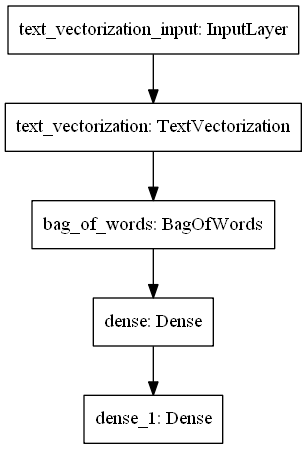

In [11]:
def build_model_fn(n_layers=1, n_neurons=100, act_fn="relu"):
    model = keras.models.Sequential([
        Text_Vectorizer,
        bag_of_words,
    ])
    for _ in range(n_layers):
        model.add(keras.layers.Dense(n_neurons, activation=act_fn))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
    # binary crossentropy because it's a binary classification task
    return model

model = build_model_fn()
keras.utils.plot_model(model)

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [13]:
for item in train_set:
    print(item)
    break

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'Because some people, like me, like to know EVERYTHING about a movie even if they plan to see it, including the ending. Anyway, here\'s the ending as I remember it, because I couldn\'t have been more than 8 yrs old when I saw it for the first and only time on TV. But I\'ll tell ya, it sure scared the little kid that I was, and I thought about it for days afterward, and it still stands out in my mind to this day, even though some of the details are a little vague. Abe Vigoda was in this movie? I don\'t remember that! I didn\'t even remember that ol\' Barnabus was in this movie, and I LOVED Dark Shadows. So, at the end, the lead character (Belinda Montgomery?) is lured by the Judge (Joseph Cotton, I\'m guessing, even though I remember it as him being an old family physician or something instead of a judge; see how memory fades?) to the wedding place, which as I remember it is in a cavern of some kind? Maybe I\'ve got that wrong; and 

In [14]:
model.fit(train_set, epochs=10)

Epoch 1/10
782/782 [==============================] - 5s 5ms/step - loss: 0.5833 - accuracy: 0.6813
Epoch 2/10
782/782 [==============================] - 4s 4ms/step - loss: 0.4640 - accuracy: 0.7749
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.4095 - accuracy: 0.8177
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3370 - accuracy: 0.8623
Epoch 5/10
782/782 [==============================] - 4s 4ms/step - loss: 0.2543 - accuracy: 0.9101
Epoch 6/10
782/782 [==============================] - 4s 4ms/step - loss: 0.1716 - accuracy: 0.9543
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1064 - accuracy: 0.9800
Epoch 8/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0604 - accuracy: 0.9954
Epoch 9/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0331 - accuracy: 0.9991
Epoch 10/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0191 - accuracy: 0.9998

In [15]:
# e

def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    print(not_pad)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    print(n_words)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    print(sqrt_n_words)
    return tf.reduce_mean(inputs, axis=1) * sqrt_n_words

def build_model_fn_with_embedding(n_layers=1, n_neurons=100, act_fn="relu", out_dim=20):
    model = keras.models.Sequential([
        Text_Vectorizer,
    ])
    model.add(keras.layers.Embedding(input_dim=OH_columns, output_dim=out_dim, mask_zero=True))
    # mask_zero is supposed to convert the 0 values in the/<pad> tokens to zero vectors
    # it doesn't work?
    model.add(keras.layers.Lambda(compute_mean_embedding))
    for _ in range(n_layers):
        model.add(keras.layers.Dense(n_neurons, activation=act_fn))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
    return model


+ mask_zero


    Boolean, whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when using recurrent layers which may take variable length input. If this is True, then all subsequent layers in the model need to support masking or an exception will be raised. If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal size of vocabulary + 1).

+ mask_zero with a subsequent Lambda layer
+ https://stackoverflow.com/questions/47485216/how-does-mask-zero-in-keras-embedding-layer-work
+ https://stackoverflow.com/questions/49961683/how-to-use-the-result-of-embedding-with-mask-zero-true-in-keras#:~:text=If%20you%20set%20mask_zero=True%20in%20your%20embeddings,%20then,to%20understand%20the%20%22masked%22%20information%20will%20use%20them.

+ apparently, mask_zero doesn't actually give zero vectors, but they are *like* zero vectors as they are not considered in future layers that support mask_zero

In [16]:
# f

model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 7s 8ms/step - loss: 0.0161 - accuracy: 0.9995 - val_loss: 1.0386 - val_accuracy: 0.7157
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: 0.0085 - accuracy: 0.9999 - val_loss: 1.1099 - val_accuracy: 0.7182
Epoch 3/5
782/782 [==============================] - 6s 7ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.1577 - val_accuracy: 0.7194
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.2121 - val_accuracy: 0.7205
Epoch 5/5
782/782 [==============================] - 6s 7ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.2717 - val_accuracy: 0.7196
